In [69]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from dateutil.parser import parse
import datetime
import re

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

In [70]:
interviews = pd.read_csv("data/raw/Interview.csv")

In [71]:
interviews.head()

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Are you clear with the venue details and the landmark.,Has the call letter been shared,Expected Attendance,Observed Attendance,Marital Status,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 1,Male,Chennai,...,Yes,Yes,Yes,No,Single,NaN,NaN,NaN,NaN,NaN
1,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 2,Male,Chennai,...,Yes,Yes,Yes,No,Single,NaN,NaN,NaN,NaN,NaN
2,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 3,Male,Chennai,...,NaN,NaN,Uncertain,No,Single,NaN,NaN,NaN,NaN,NaN
3,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 4,Male,Chennai,...,Yes,Yes,Uncertain,No,Single,NaN,NaN,NaN,NaN,NaN
4,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 5,Male,Chennai,...,Yes,Yes,Uncertain,No,Married,NaN,NaN,NaN,NaN,NaN


In [72]:
interviews.tail()

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Are you clear with the venue details and the landmark.,Has the call letter been shared,Expected Attendance,Observed Attendance,Marital Status,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
1229,07.05.2016,Pfizer,Pharmaceuticals,Chennai,Niche,Biosimiliars,Scheduled,Candidate 1230,Male,Chennai,...,Yes,Yes,Yes,Yes,Single,NaN,NaN,NaN,NaN,NaN
1230,06.05.2016,Pfizer,Pharmaceuticals,Chennai,Niche,Biosimiliars,Scheduled,Candidate 1231,Male,Chennai,...,Yes,Yes,Yes,Yes,Married,NaN,NaN,NaN,NaN,NaN
1231,06.05.2016,Pfizer,Pharmaceuticals,Chennai,Niche,generic drugs – RA,Scheduled,Candidate 1232,Male,Chennai,...,Yes,Yes,Yes,Yes,Single,NaN,NaN,NaN,NaN,NaN
1232,06.05.2016,Pfizer,Pharmaceuticals,Chennai,Niche,generic drugs – RA,Scheduled,Candidate 1233,Female,Chennai,...,NaN,NaN,Uncertain,Yes,Single,NaN,NaN,NaN,NaN,NaN
1233,NaN,﻿﻿,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
#the last row is redundant, drop it
interviews = interviews.drop([1233])

#last 5 columns are empty, drop them
interviews = interviews.drop(["Name(Cand ID)", "Unnamed: 23", "Unnamed: 24", "Unnamed: 25", "Unnamed: 26", "Unnamed: 27"], axis = 1)

In [74]:
interviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233 entries, 0 to 1232
Data columns (total 22 columns):
Date of Interview                                                                                     1233 non-null object
Client name                                                                                           1233 non-null object
Industry                                                                                              1233 non-null object
Location                                                                                              1233 non-null object
Position to be closed                                                                                 1233 non-null object
Nature of Skillset                                                                                    1233 non-null object
Interview Type                                                                                        1233 non-null object
Gender                          

In [75]:
interviews = interviews.rename(index=str, columns={
    "Have you obtained the necessary permission to start at the required time": "question_permission",
    "Hope there will be no unscheduled meetings": "question_no_unscheduled_meetings",
    "Can I Call you three hours before the interview and follow up on your attendance for the interview": "question_follow_up",
    "Can I have an alternative number/ desk number. I assure you that I will not trouble you too much": "question_alternative_number",
    "Have you taken a printout of your updated resume. Have you read the JD and understood the same": "question_resume_printout",
    "Are you clear with the venue details and the landmark.": "question_venue",
    "Has the call letter been shared": "question_call_letter"
})

In [76]:
interviews.columns

Index(['Date of Interview', 'Client name', 'Industry', 'Location',
       'Position to be closed', 'Nature of Skillset', 'Interview Type',
       'Gender', 'Candidate Current Location', 'Candidate Job Location',
       'Interview Venue', 'Candidate Native location', 'question_permission',
       'question_no_unscheduled_meetings', 'question_follow_up',
       'question_alternative_number', 'question_resume_printout',
       'question_venue', 'question_call_letter', 'Expected Attendance',
       'Observed Attendance', 'Marital Status'],
      dtype='object')

In [77]:
interviews.update(interviews[[
    "question_permission", "question_no_unscheduled_meetings", "question_follow_up",
    "question_alternative_number", "question_resume_printout", "question_venue", "question_call_letter"
]].fillna("Unknown"))

In [78]:
for column in interviews.columns:
    print("-- " + column)
    print(interviews[column].value_counts())


-- Date of Interview
06.02.2016               220
04/12/16                  86
13.04.2016                84
25.06.2015                43
02.09.2016                43
21.4.16                   38
22.01.2016                34
07.05.2016                31
03.04.2015                30
14.01.2016                28
26.02.2016                26
27.02.2016                26
05/11/2016                25
20.08.2016                25
25.5.2016                 24
23.02.2016                22
02.12.2015                19
19.06.2015                18
19.03.16                  17
30.01.2016                16
09-01-2016                15
13.06.2016                15
11.5.16                   14
21.4.2016                 14
30.1.16                   14
25-5-2016                 14
22.03.2016                13
13/03/2015                13
25.05.2016                12
3.6.16                    12
                        ... 
28.08.2016 & 9.30 AM       2
03/06/16                   2
28.08.2016 & 10.30 AM 

In [79]:
def parse_date(date_string):
    try:
        preprocessed = re.sub(r"[-–]", ' ', date_string)
        preprocessed = re.sub(r"\s{2,}", ' ', preprocessed)
        preprocessed = re.sub(r"(&.*)", ' ', preprocessed)
        return parse(preprocessed, ignoretz = True, dayfirst = True)
    except (ValueError, TypeError) as e:
        raise RuntimeError('Cannot be parsed as a date: ' + date_string) from e
        
        
assert parse_date("06.02.2016") == datetime.datetime(2016, 2, 6, 0, 0)
assert parse_date("04/12/16") == datetime.datetime(2016, 12, 4, 0, 0)
assert parse_date("21.4.16") == datetime.datetime(2016, 4, 21, 0, 0)
assert parse_date("15 Apr 16") == datetime.datetime(2016, 4, 15, 0, 0)
assert parse_date("09-01-2016") == datetime.datetime(2016, 1, 9, 0, 0)
assert parse_date("09 01 2016") == datetime.datetime(2016, 1, 9, 0, 0)
assert parse_date("25 – Apr-16") == datetime.datetime(2016, 4, 25, 0, 0)
assert parse_date("21-Apr -16") == datetime.datetime(2016, 4, 21, 0, 0)
assert parse_date("28.8.2016 & 12.00 PM") == datetime.datetime(2016, 8, 28, 0, 0)

In [80]:
class DateParser(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name = "Date of Interview"):
        self.attribute_name = attribute_name
        self.__days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        self.__months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        
        
    def __create_date_columns(self, value):
        date = parse_date(value)
        return pd.Series({
                "interview_month": self.__months[date.month - 1],
                "interview_day_of_week": self.__days_of_week[date.weekday()]
            })
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X[self.attribute_name].apply(
            lambda date: self.__create_date_columns(date)
        )
        dataframe = pd.concat([result, X], axis=1)
        return dataframe.drop([self.attribute_name], axis = 1)

In [81]:
def parse_city_name(city_name):
        preprocessed = re.sub(r"(\W)", '', city_name)
        return preprocessed.title()

class CityNameParser(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: parse_city_name(name)
        )
        return result
    
assert parse_city_name("Chennai") == "Chennai"
assert parse_city_name("- Cochin-") == "Cochin"
assert parse_city_name("CHENNAI") == "Chennai"
assert parse_city_name("chennai") == "Chennai"

In [82]:
class MergeITIndustries(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: "IT" if name.startswith("IT") else name
        )
        return result

In [83]:
#sorry, just gut feeling, due to the lack of a domain expert
class MergePositionType(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
        self.mapping = {
            "Routine": "Routine",
            "Dot Net": "Routine",
            "Selenium testing": "Routine",
            "Niche": "Niche",
            "Trade Finance": "Niche",
            "AML": "Niche",
            "Production- Sterile": "Niche",
        }
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: self.mapping.get(name, "Routine")
        )
        return result

In [84]:
#sorry, just gut feeling, due to the lack of a domain expert
class MergeSkillsetType(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
        
    def __map_skill(self, skill):
        name = skill.lower()
        if "java" in name: #I checked the dataset, there were no JavaScript, so don't worry ;)
            return "Java Developer"
        elif "testing" in name:
            return "Tester"
        elif "oracle" in name:
            return "Oracle"
        elif "aml" in name or "kyc" in name or "cdd" in name or "regulatory" in name:
            return "Regulatory"
        elif "sccm" in name:
            return "IT Infrastructure"
        elif "banking" in name or "lending" in name or name == "l & l":
            return "Banking Operations"
        elif "software engineer" in name or "developer" in name:
            return "Other software engineer"
        elif "lead" in name or "manager" in name or "management" in name:
            return "Management"
        elif "r & d" in name or "r&d" in name:
            return "R&D"
        elif "analyst" in name:
            return "Analyst"
        elif "publishing" in name:
            return "Publishing"
        elif "production" in name:
            return "Production"
        elif "fresher" in name:
            return "Fresher"
        elif "accounting operations" in name:
            return "Accounting Operations"
        elif "routine" in name:
            return "Routine"
        elif "sas" in name:
            return "SAS"
        elif "hadoop" in name:
            return "Hadoop"
        elif "dot net" in name:
            return ".NET"
        elif "etl" in name:
            return "ETL"
        elif "emea" in name:
            return "EMEA"
        elif "global labelling" in name:
            return "Global Labelling"
        elif "biosimiliars" in name:
            return "Biosimiliars"
        elif "product control" in name:
            return "Product Control"
        else:
            return "Other"
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: self.__map_skill(name)
        )
        return result

In [85]:
class ParseInterviewType(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name

    def __convert_interview_type(self, name):
        interview_type = name.lower()
        if "scheduled" in interview_type or "sceduled" in interview_type:
            return "Scheduled"
        else:
            return "Walk-in"
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: self.__convert_interview_type(name)
        )
        return result

In [86]:
class ParseYesNoAnswer(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name

    def __convert_answer(self, name):
        name = str(name).lower()
        if name == "yes":
            return "Yes"
        elif name == "unknown":
            return "Unknown"
        else:
            return "No"
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: self.__convert_answer(name)
        )
        return result

In [87]:
class ParseExpectedAttendanceAnswer(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name

    def __convert_answer(self, name):
        name = str(name).lower()
        if name == "yes":
            return "Yes"
        elif name == "uncertain":
            return "Uncertain"
        elif name == "no":
            return "No"
        else:
            return "Yes"
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.copy()
        result[self.attribute_name] = X[self.attribute_name].apply(
            lambda name: self.__convert_answer(name)
        )
        return result

In [88]:
class RelativeLocation(BaseEstimator, TransformerMixin):
    def __create_columns(self, value):
        return pd.Series({
            "current_same_as_location": value["Candidate Current Location"] == value["Location"],
            "current_same_as_job_location": value["Candidate Current Location"] == value["Candidate Job Location"],
            "current_same_as_venue_location": value["Candidate Current Location"] == value["Interview Venue"],
            "native_same_as_location": value["Candidate Native location"] == value["Location"],
            "native_same_as_job_location": value["Candidate Native location"] == value["Candidate Job Location"],
            "native_same_as_venue_location": value["Candidate Native location"] == value["Interview Venue"]
        })
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        result = X.apply(
            lambda row: self.__create_columns(row), axis = 1
        )
        dataframe = pd.concat([result, X], axis=1)
        return dataframe

In [89]:
preprocessing_pipeline = Pipeline([
    ("extract_interview_date", DateParser()),
    ("normalize_location", CityNameParser("Location")),
    ("normalize_candidate_current_location", CityNameParser("Candidate Current Location")),
    ("normalize_candidate_job_location", CityNameParser("Candidate Job Location")),
    ("normalize_interview_venue", CityNameParser("Interview Venue")),
    ("normalize_candidate_native_location", CityNameParser("Candidate Native location")),
    ("merge_it_industries", MergeITIndustries("Industry")),
    ("merge_position_type", MergePositionType("Position to be closed")),
    ("merge_skillset_type", MergeSkillsetType("Nature of Skillset")),
    ("parse_interview_types", ParseInterviewType("Interview Type")),
    ("convert_permission_answer", ParseYesNoAnswer("question_permission")),
    ("convert_unscheduled_meetings_answer", ParseYesNoAnswer("question_no_unscheduled_meetings")),
    ("convert_premeeting_call_answer", ParseYesNoAnswer("question_follow_up")),
    ("convert_alternative_number_answer", ParseYesNoAnswer("question_alternative_number")),
    ("convert_printout_answer", ParseYesNoAnswer("question_resume_printout")),
    ("convert_venue_answer", ParseYesNoAnswer("question_venue")),
    ("convert_call_letter_answer", ParseYesNoAnswer("question_call_letter")),
    ("convert_expected_attendance_answer", ParseExpectedAttendanceAnswer("Expected Attendance")),
    ("convert_observed_attendance_answer", ParseYesNoAnswer("Observed Attendance")),
    #("add_relations_between_locations", RelativeLocation()) # results are getting worse ;)
])

preprocessed = preprocessing_pipeline.transform(interviews)

In [90]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1234)
for train_index, test_index in split.split(preprocessed, preprocessed["Observed Attendance"]):
    train_set = preprocessed.iloc[train_index]
    test_set = preprocessed.iloc[test_index]

In [91]:
train_set_features = train_set.drop("Observed Attendance", axis = 1)
train_set_label = train_set["Observed Attendance"].copy()

In [92]:
# Stolen from https://github.com/scikit-learn/scikit-learn/blob/19e2772/sklearn/preprocessing/data.py#L2871 ;)
# it will be be available in the next version of scikitlearn
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
                and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

In [93]:
encoding = Pipeline([
    ("one_hot_encoder", CategoricalEncoder())
])

encoded_train_set = encoding.fit_transform(train_set_features)

label_encoder = LabelEncoder()
encoded_train_set_labels = label_encoder.fit_transform(train_set_label)

In [121]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

def score_classifiers(classifiers, input_data = encoded_train_set.toarray(), labels = encoded_train_set_labels):
    roc_auc_results = []
    for (classifier, name) in classifiers:
        predictions = cross_val_predict(
            classifier,
            input_data, labels,
            cv = 10
        )
        roc_auc = roc_auc_score(predictions, labels)
        fpr, tpr, _ = roc_curve(predictions, labels)
        roc_auc_results.append((roc_auc, name))
        plt.plot(fpr, tpr, linewidth = 2, label = name)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    for (roc_auc, name) in sorted(roc_auc_results, key=lambda x: x[0]):
        print("ROC AUC (" + name + "): " + str(roc_auc))


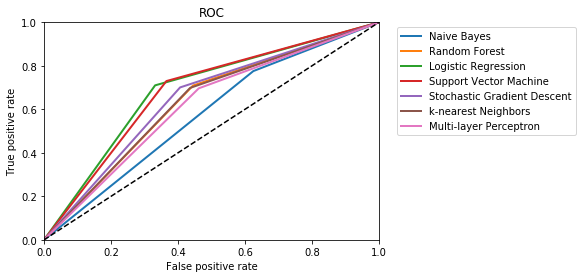

ROC AUC (Naive Bayes): 0.575431034483
ROC AUC (Multi-layer Perceptron): 0.617277344078
ROC AUC (k-nearest Neighbors): 0.631152761854
ROC AUC (Random Forest): 0.632190000252
ROC AUC (Stochastic Gradient Descent): 0.647268700787
ROC AUC (Support Vector Machine): 0.682321466412
ROC AUC (Logistic Regression): 0.689316978795


In [95]:
score_classifiers([
    (GaussianNB(), "Naive Bayes"),
    (RandomForestClassifier(), "Random Forest"),
    (LogisticRegression(), "Logistic Regression"),
    (SVC(), "Support Vector Machine"),
    (SGDClassifier(max_iter = 1000), "Stochastic Gradient Descent"),
    (KNeighborsClassifier(), "k-nearest Neighbors"),
    (MLPClassifier(), "Multi-layer Perceptron")
])

In [96]:
from sklearn.feature_selection import RFECV

feature_selection = RFECV(RandomForestClassifier(), step=1, cv=10)
feature_selection = feature_selection.fit(encoded_train_set.toarray(), encoded_train_set_labels)

print(feature_selection.support_)
print(feature_selection.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False  True
 False False False  True False  True  True False]
[

In [97]:
only_important_features = encoded_train_set.toarray()[:, feature_selection.support_]

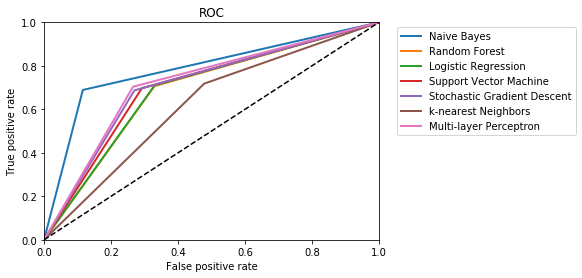

ROC AUC (k-nearest Neighbors): 0.619961846004
ROC AUC (Random Forest): 0.688537653528
ROC AUC (Logistic Regression): 0.689904975134
ROC AUC (Support Vector Machine): 0.702453796204
ROC AUC (Stochastic Gradient Descent): 0.708684016242
ROC AUC (Multi-layer Perceptron): 0.719141747692
ROC AUC (Naive Bayes): 0.786661941048


In [98]:
score_classifiers([
    (GaussianNB(), "Naive Bayes"),
    (RandomForestClassifier(), "Random Forest"),
    (LogisticRegression(), "Logistic Regression"),
    (SVC(), "Support Vector Machine"),
    (SGDClassifier(max_iter = 1000), "Stochastic Gradient Descent"),
    (KNeighborsClassifier(), "k-nearest Neighbors"),
    (MLPClassifier(), "Multi-layer Perceptron")
], only_important_features)

{'degree': 3, 'kernel': 'poly', 'shrinking': True}


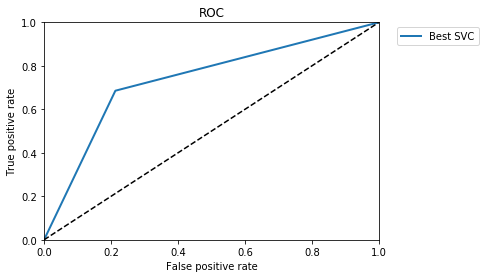

ROC AUC (Best SVC): 0.736343119885


In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
       'kernel': ["linear", "poly", "rbf", "sigmoid"],
       'degree': randint(1, only_important_features.shape[1]),
       'shrinking': [True, False]
  }

random_search = RandomizedSearchCV(estimator=SVC(), param_distributions=param_grid, n_iter=1000)
random_search.fit(only_important_features, encoded_train_set_labels)
best_classifier = random_search.best_estimator_

print(random_search.best_params_)
score_classifiers([
    (best_classifier, "Best SVC")
], only_important_features)

{'bootstrap': True, 'criterion': 'entropy', 'max_features': 5, 'min_samples_split': 7, 'n_estimators': 2}


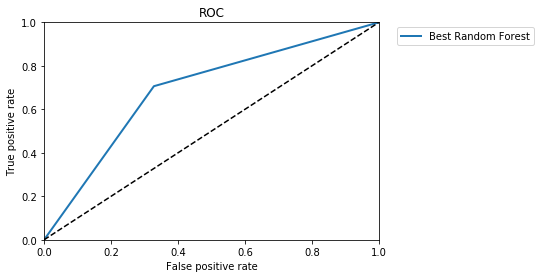

ROC AUC (Best Random Forest): 0.689178334097


In [102]:
# limited feature set
classifier = RandomForestClassifier()
param_grid = {
        'n_estimators': randint(1, 20),
        'criterion': ["gini", "entropy"],
        'max_features': randint(1, only_important_features.shape[1]),
        'min_samples_split': randint(2, 8),
        'bootstrap': [True, False]
  }

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=1000)
random_search.fit(only_important_features, encoded_train_set_labels)
best_classifier = random_search.best_estimator_

print(random_search.best_params_)
score_classifiers([
    (best_classifier, "Best Random Forest")
], only_important_features)

{'bootstrap': False, 'criterion': 'entropy', 'max_features': 1, 'min_samples_split': 6, 'n_estimators': 11}


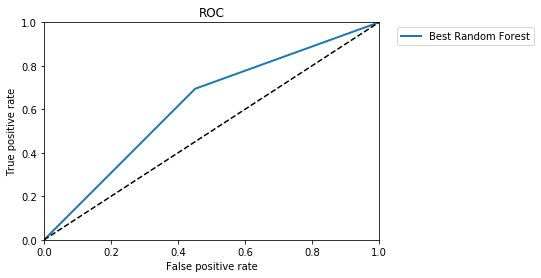

ROC AUC (Best Random Forest): 0.6216875412


In [103]:
#full feature set
classifier = RandomForestClassifier()
param_grid = {
        'n_estimators': randint(1, 20),
        'criterion': ["gini", "entropy"],
        'max_features': randint(1, encoded_train_set.toarray().shape[1]),
        'min_samples_split': randint(2, 8),
        'bootstrap': [True, False]
  }

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=1000)
random_search.fit(encoded_train_set.toarray(), encoded_train_set_labels)
best_classifier = random_search.best_estimator_

print(random_search.best_params_)
score_classifiers([
    (best_classifier, "Best Random Forest")
], encoded_train_set.toarray())

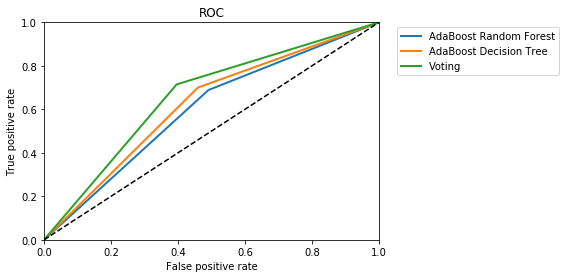

ROC AUC (AdaBoost Random Forest): 0.598898530175
ROC AUC (AdaBoost Decision Tree): 0.620360644258
ROC AUC (Voting): 0.659336956522


In [104]:
#full feature set
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

voting_all = VotingClassifier(estimators=[
    ("Naive Bayes", GaussianNB()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("Support Vector Machine", SVC()),
    ("Stochastic Gradient Descent", SGDClassifier(max_iter = 1000)),
    ("k-nearest Neighbors", KNeighborsClassifier()),
    ("Multi-layer Perceptron", MLPClassifier())
], voting='hard')

score_classifiers([
    (AdaBoostClassifier(base_estimator=RandomForestClassifier()), "AdaBoost Random Forest"),
    (AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), "AdaBoost Decision Tree"),
    (voting_all, "Voting")
])

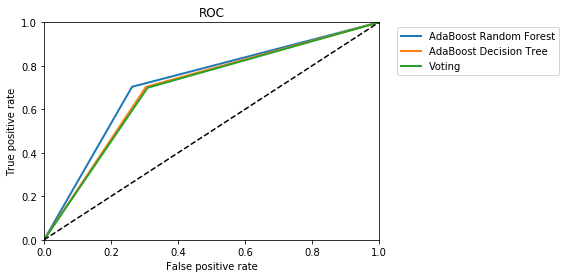

ROC AUC (Voting): 0.695028236076
ROC AUC (AdaBoost Decision Tree): 0.699486958706
ROC AUC (AdaBoost Random Forest): 0.720396972505


In [105]:
#limited feature set
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

voting_all = VotingClassifier(estimators=[
    ("Naive Bayes", GaussianNB()),
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("Support Vector Machine", SVC()),
    ("Stochastic Gradient Descent", SGDClassifier(max_iter = 1000)),
    ("k-nearest Neighbors", KNeighborsClassifier()),
    ("Multi-layer Perceptron", MLPClassifier())
], voting='hard')

score_classifiers([
    (AdaBoostClassifier(base_estimator=RandomForestClassifier()), "AdaBoost Random Forest"),
    (AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), "AdaBoost Decision Tree"),
    (voting_all, "Voting")
], only_important_features)

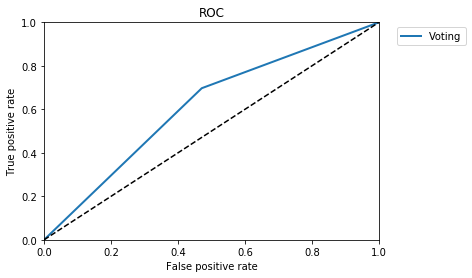

ROC AUC (Voting): 0.613084302919


In [108]:
#full feature set
voting_best = VotingClassifier(estimators=[
    ("AdaBoost Random Forest", AdaBoostClassifier(base_estimator=RandomForestClassifier())),
    ("AdaBoost Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Random Forest (after random search)", RandomForestClassifier(bootstrap = True, criterion = "entropy", max_features = 5, min_samples_split = 7, n_estimators = 2)),
    ("Support Vector Machine (after random search)", SVC(degree = 3, kernel = "poly", shrinking = True)),
    ("Naive Bayes", GaussianNB()),
], voting='hard')

score_classifiers([
    (voting_best, "Voting")
])

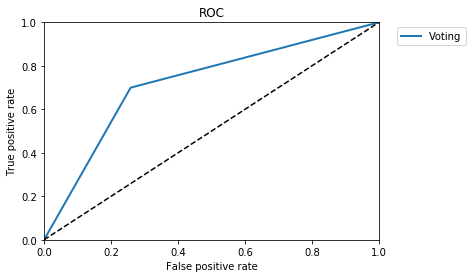

ROC AUC (Voting): 0.720569515053


In [109]:
#limited feature set
voting_best = VotingClassifier(estimators=[
    ("AdaBoost Random Forest", AdaBoostClassifier(base_estimator=RandomForestClassifier())),
    ("AdaBoost Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Random Forest (after random search)", RandomForestClassifier(bootstrap = True, criterion = "entropy", max_features = 5, min_samples_split = 7, n_estimators = 2)),
    ("Support Vector Machine (after random search)", SVC(degree = 3, kernel = "poly", shrinking = True)),
    ("Naive Bayes", GaussianNB()),
], voting='hard')

score_classifiers([
    (voting_best, "Voting")
], only_important_features)

{'weights': array([ 4, 16, 29,  9, 15])}


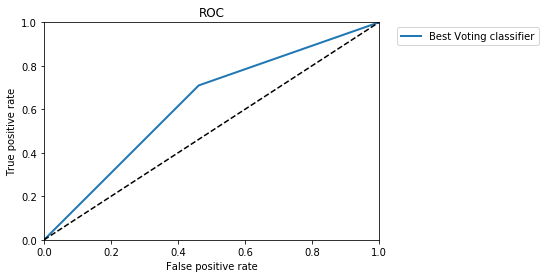

ROC AUC (Best Voting classifier): 0.624028142199


In [118]:
classifier = VotingClassifier(estimators=[
    ("AdaBoost Random Forest", AdaBoostClassifier(base_estimator=RandomForestClassifier())),
    ("AdaBoost Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Random Forest (after random search)", RandomForestClassifier(bootstrap = True, criterion = "entropy", max_features = 5, min_samples_split = 7, n_estimators = 2)),
    ("Support Vector Machine (after random search)", SVC(degree = 3, kernel = "poly", shrinking = True)),
    ("Naive Bayes", GaussianNB()),
], voting='hard')
param_grid = {
        'weights': np.random.randint(1, 40, size=(1000, 5))
}

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=1000)
random_search.fit(encoded_train_set.toarray(), encoded_train_set_labels)
best_classifier = random_search.best_estimator_

print(random_search.best_params_)
score_classifiers([
    (best_classifier, "Best Voting classifier")
], encoded_train_set.toarray())

{'weights': array([30, 21, 24,  9, 22])}


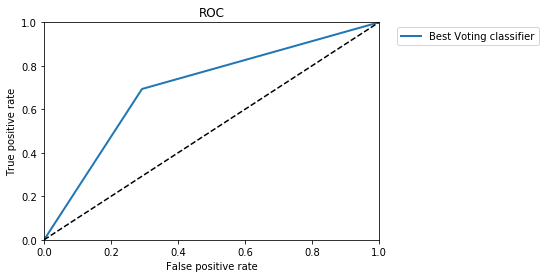

ROC AUC (Best Voting classifier): 0.700582974549


In [120]:
classifier = VotingClassifier(estimators=[
    ("AdaBoost Random Forest", AdaBoostClassifier(base_estimator=RandomForestClassifier())),
    ("AdaBoost Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Random Forest (after random search)", RandomForestClassifier(bootstrap = True, criterion = "entropy", max_features = 5, min_samples_split = 7, n_estimators = 2)),
    ("Support Vector Machine (after random search)", SVC(degree = 3, kernel = "poly", shrinking = True)),
    ("Naive Bayes", GaussianNB()),
], voting='hard')
param_grid = {
        'weights': np.random.randint(1, 40, size=(500, 5))
}

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=500)
random_search.fit(only_important_features, encoded_train_set_labels)
best_classifier = random_search.best_estimator_

print(random_search.best_params_)
score_classifiers([
    (best_classifier, "Best Voting classifier")
], only_important_features)

In [148]:
# mistake during encoding... removing 3 entries with unknown locations
test_set = test_set[~test_set["Candidate Native location"].isin(['Baddi','Mysore','Panjim'])]

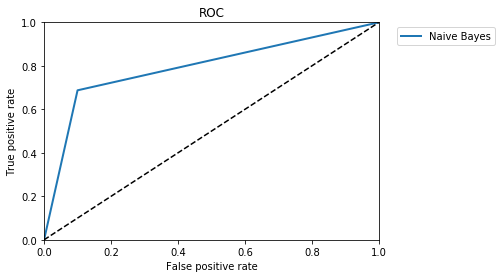

ROC AUC (Naive Bayes): 0.79375


In [144]:
# The final scoring using the test set
test_set_features = test_set.drop("Observed Attendance", axis = 1)
test_set_label = test_set["Observed Attendance"].copy()

encoded_test_set = encoding.transform(test_set_features)
encoded_test_set_labels = label_encoder.transform(test_set_label)

selected_test_set = encoded_test_set.toarray()[:, feature_selection.support_]

score_classifiers([
    (GaussianNB(), "Naive Bayes") #and all of that just to use a Naive Bayes classifier with default parameters
], selected_test_set, encoded_test_set_labels)